# Graph Machine Learning (Parte 2). Análisis de listas de amigos en Facebook 

> ¿Te has preguntado alguna vez como se las arregla Facebook para recomendarte futuros amigos? ... Pues sí, como te puedes imaginar, utiliza algoritmos predictivos basados en grafos! En este artículo haremos una introducción a analítica de grafos dobre Facebook.

Las redes sociales son un ámbito muy interesante para aplicar analítica de grafos. Los nodos de este tipo de redes normalmente corresponden a los usuarios y los ejes a los usuarios son amigos entre sí. Como hemos visto en el primer artículo de grafos, esta red se modela a un grafo unipartito no direccional no ponderado. Este grafo puede además tener información sobre nodos (nombre, aficiones, edad, sexo, etc.) o sobre los ejes (ej. fecha de inicio de la amistad)

Aunque esta es la configuración más común, también es posible modelar una red social con otro tipo de grafos, e.j., el número de "likes" que envían dos amigos entre sí (te dejo que pienses qué tipo de grafo sería).

Algunas de las tareas que podremos realizar con redes sociales son:

1. Investigación de la red para detectar nodos importantes: Análisis exploratorio de la red.
2. Detección de grupos de amigos o comunidades de usuarios similares: detección de communidades.
3. Predicción de nuevas amistades: "link prediction".
4. Predicción de características de los usuarios en base a las características de sus amistades: "node prediction.

En este artículo plantearemos un caso de estudio sobre las tareas 1 y 2.




# Datos: Círculos sociales de Facebook (Stanford)


La base de datos "Social circles: Facebook" fue creada por investigadores de la universidad de Stanford en el año 2012. Este conjunto de datos consta de redes de amistad de Facebook. Los datos se recopilaron de usuarios de esta plataforma incluyendo características de nodos (perfiles) y redes de amistad.

Los datos de Facebook se anonimizaron reemplazando los nombres y otras identificaciones por un índice numérico. Las características de los usuarios también fueron anonimizadas de tal forma que no pueda interpretarse el significado de las características pero sí se puedan relacionar unos usuarios con otros.mPor ejemplo, donde el conjunto de datos original puede haber contenido una característica "política=Derechas", los nuevos datos simplemente contendrían "política=característica anonimizada 1". Por lo tanto, utilizando los datos anonimizados es posible determinar si dos usuarios tienen las mismas afiliaciones políticas, pero no lo que representan sus afiliaciones políticas individuales. 

Para este ejemplo, únicamente trabajaremos con la matriz de adyacencia de los datos. Si no te suena lo que es, te recomiendo que repases el artículo anterior ;).

Los datos también están disponibles en Google+ y Twitter, te animo analizarlas por tu cuenta!


J. McAuley and J. Leskovec. Learning to Discover Social Circles in Ego Networks. NIPS, 2012.


# Lectura de los datos

Los datos puedes descargarlos de la web de Stanford (https://snap.stanford.edu/data/ego-Facebook.html), o desde cienciadedatos.net.

In [111]:
# Instalación de librerías
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# leemos el dataframe
facebook = pd.read_csv("../data/facebook_combined.txt", header=None, sep=" ",names=["user_1", "user_2"])

In [112]:
facebook

,user_1,user_2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
88229,4026,4030
88230,4027,4031
88231,4027,4032
88232,4027,4038


Y como vimos, creamos el grafo desde un dataframe utilizando networkx


In [113]:
import networkx as nx

G = nx.from_pandas_edgelist(facebook, source="user_1", target="user_2")

In [114]:
G

Ya tenemos cargado nuestro grafo! Un grafo no dirigico

In [115]:
G.is_directed()

False

matriz de adyacencia

In [116]:
nx.adj_matrix(G).todense()

matrix([[0, 1, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

# Análisis exploratorio

En el la web oficial de los de los datos encontramos las siguientes estadísticas.

| Estadísticas de conjuntos de datos | |
|---------------------------------------- |-------------- |
| Nodos | 4,039 |
| Ejes | 88,234 |
| Nodos en el cluster más grande | 4,039 (1.000) |
| Ejes en el cluster más grande | 88,234 (1.000) |
| Coeficiente de agrupamiento medio | 0,6055 |
| Diámetro (camino más largo y más corto) | 8 |
| Diámetro efectivo percentil 90 | 4.7 |

¡Vamos a ver a intentar replicarlas y calcular algunas otras!

Para más detalles de los cálculos, visita el primer artículo de la serie.

In [117]:
print(f"Numero de nodos: {G.number_of_nodes():,}")
print(f"Numero de ejes: {G.number_of_edges():,}")
print(f"Average degree: {((G.number_of_edges()*2) / G.number_of_nodes()):,.3}")

degrees = dict(nx.degree(G))
print(f"Número de amigos del usuario con más amigos (Max degree): {max(degrees.values()):,}")
print(f"Número de amigos del usuario con menos amigos (Min degree): {min(degrees.values()):,}")
print(f"Densidad del grafo: {nx.density(G):,.2}")
# print(f"Diametro: {nx.diameter(G):,.2}")




Numero de nodos: 4,039
Numero de ejes: 88,234
Average degree: 43.7
Número de amigos del usuario con más amigos (Max degree): 1,045
Número de amigos del usuario con menos amigos (Min degree): 1
Densidad del grafo: 0.011


El cálculo del betweennees centrality es mucho más pesado computacionalmente (~3 minutos) porque el tiempo de cómputo se dispara con el aumento de nodos y ejes:

$(Θ(VE +V^2)$

In [118]:
betwenneess = dict(nx.betweenness_centrality(G))
betwenneess

KeyboardInterrupt: 

In [ ]:
df1 = pd.DataFrame(
    {
        "nodes" : betwenneess.keys(),
        "betwenneess" : betwenneess.values()
    }
)
df1 = df1.set_index("nodes")

df2 = pd.DataFrame(
    {
        "nodes" : degrees.keys(),
        "degree" : degrees.values()
    }
)
df2 = df2.set_index("nodes")

nodes_df = pd.concat([df1, df2], axis=1)
nodes_df


,betwenneess,degree
nodes,,
0,1.463059e-01,347
1,2.783274e-06,17
2,7.595021e-08,10
3,1.685066e-06,17
4,1.840332e-07,10
...,...,...
4034,0.000000e+00,2
4035,0.000000e+00,1
4036,0.000000e+00,2


Text(0.5, 1.0, 'Degree vs Betweeneess centrality')

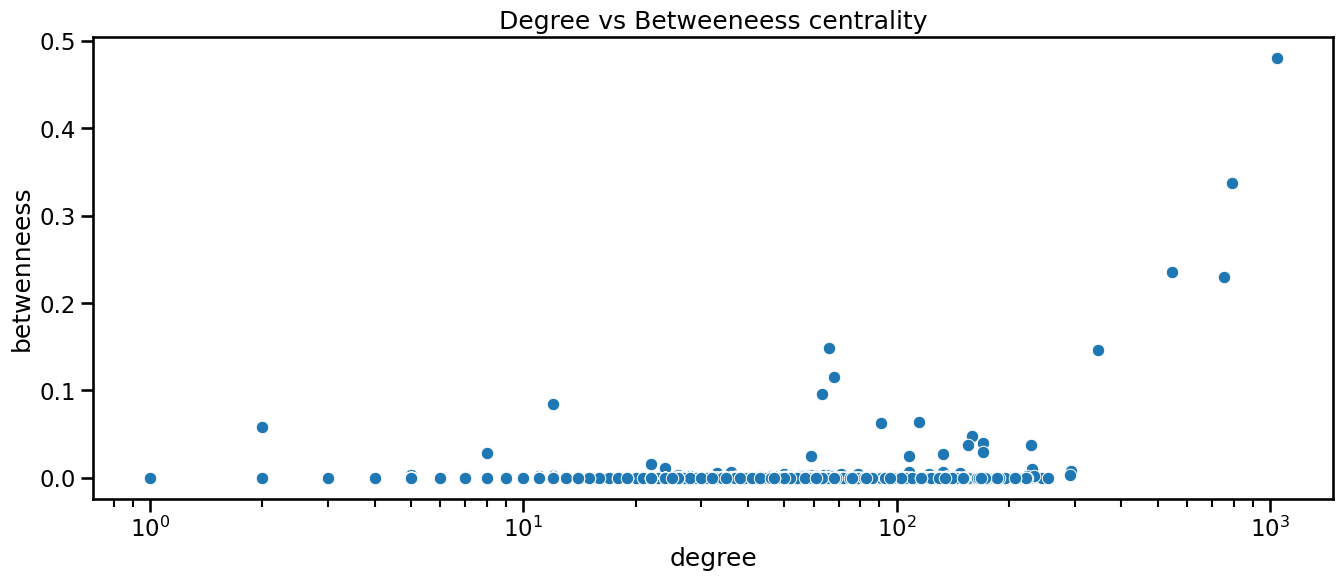

In [ ]:
import seaborn as sns
sns.set_context("talk")

plt.figure(figsize=(16,6))
sns.scatterplot(data=nodes_df, x="degree", y="betwenneess",)
plt.xscale("log")
plt.title("Degree vs Betweeneess centrality")

In [124]:
import numpy as np
from collections import Counter
from scipy.stats import poisson
from networkx import expected_degree_graph

def plot_log_degree(G: nx.Graph, bin_count: int = 50, **args):
    """Plot log degree distribution of network science

    Args:
        counter_dict (_type_): _description_
        bin_count (int, optional): _description_. Defaults to 50.
    """

    degrees = nx.degree(G)
    degrees = [x[1] for x in list(degrees)]
    degree_counts = Counter(degrees)
    x, y = zip(*degree_counts.items())

    # prep axes
    plt.xlabel("degree")
    plt.xscale("log")
    # plt.xlim(1, max(x))

    plt.ylabel("frequency")
    plt.yscale("log")
    # plt.ylim(1, max(y))
    # plot
    plt.scatter(x, y, marker="o", **args)
    return plt


def _poissongraph(n, mu):
    z = np.zeros(n)  # n is number of nodes
    for i in range(n):
        z[i] = poisson.rvs(mu)  # mu is the expected value
    G = expected_degree_graph(z)
    return G


def plot_log_degree_random(G: nx.Graph, **args):
    """Plot random network by network degree,

    Args:
        G (nx.Graph): _description_

    Returns:
        _type_: _description_
    """
    degre_avg = (2 * G.number_of_edges()) / G.number_of_nodes()
    G_r = _poissongraph(G.number_of_nodes(), degre_avg)
    return plot_log_degree(G_r, **args)

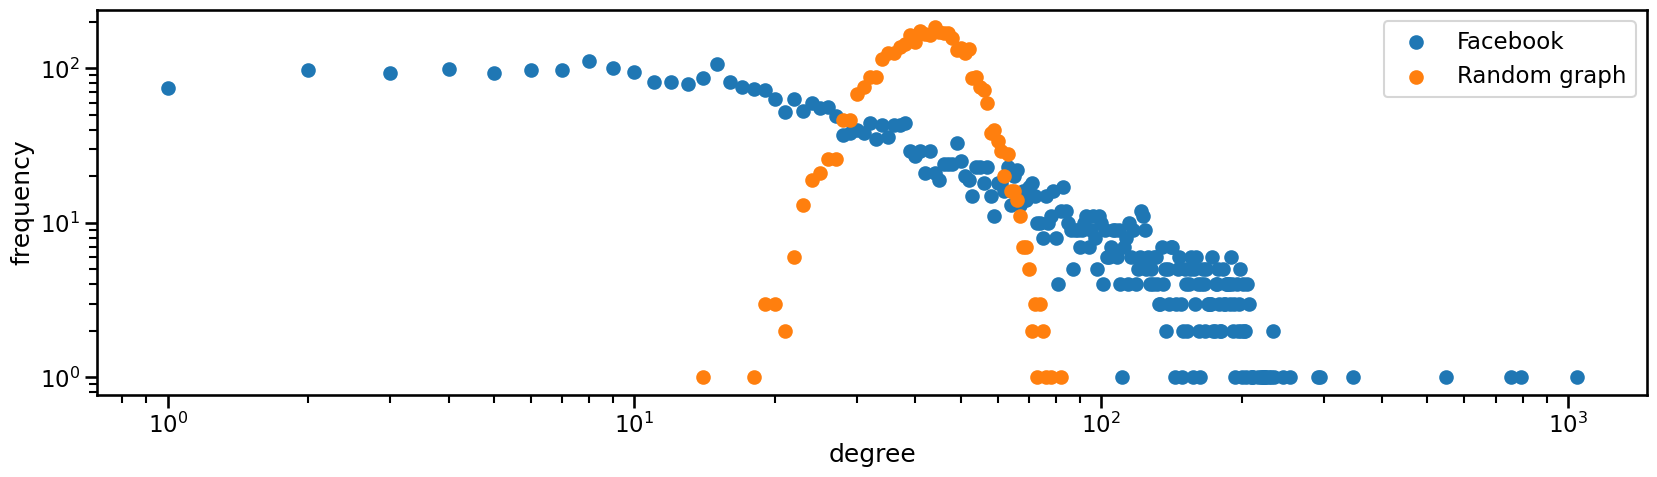

In [127]:
plt.figure(figsize=(20,5))
plot_log_degree(G)
plot_log_degree_random(G)
plt.legend(["Facebook", "Random graph"])

# Visualización de grafos

La función básica de visualización de redes es nx.draw, pero como veremos, cuando el número de nodos aumenta mucho, esta librería se queda corta, tanto en tiempo de cómputo como en capacidad de visualización.

Si pruebas e ejecutar la siguiente línea comentada podrás experimentarlo por tí mismo

In [8]:
# visualización de redes no recomendada 
# nx.draw(G, with_labels=False)


In [41]:
print(nx.info(G))

Graph with 4039 nodes and 88234 edges


In [94]:
import netwulf as nf

In [96]:
stylized_network, config = nf.visualize(G)

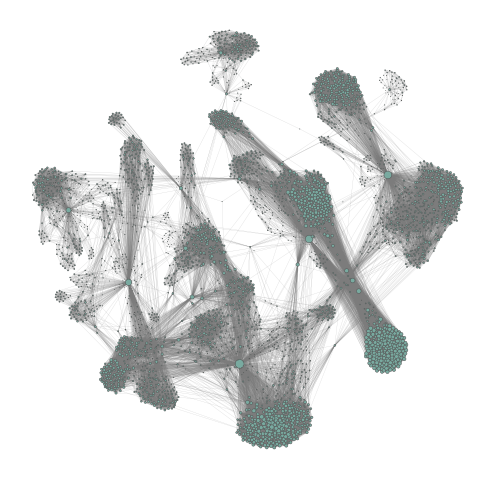

In [98]:
import matplotlib.pyplot as plt
fig, ax = nf.draw_netwulf(stylized_network)
plt.show()


In [ ]:
nodes_df

<Figure size 3000x1600 with 0 Axes>

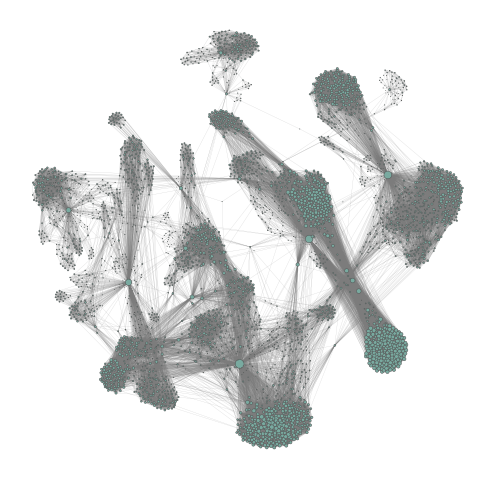

In [108]:
plt.figure(figsize=(30,16))
nf.tools.add_node_label(ax, stylized_network, 698, label='this node')
fig, ax = nf.draw_netwulf(stylized_network)
plt.show()

# Detección de comunidades

Pensando en esto intuitivamente, tiene sentido. Considérate en tus propias redes sociales como Instagram. Es posible que esté muy conectado con muchas comunidades diferentes relacionadas con las cosas que le interesan. Puede tener un seguimiento de cuentas asociadas con amigos, memes, deportes, anime, etc. Cada una de esas categorizaciones podría interpretarse como comunidades, donde usted como usuario es un nodo y los bordes se generan al conectarlo con otros usuarios que tienen intereses similares a los suyos. Por lo tanto, dentro de su propia red social, tendría una comunidad muy densa y estaría escasamente conectado con otras personas fuera de sus comunidades.



In [129]:
from community import community_louvain
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, "group")

In [130]:
stylized_network, config = nf.visualize(G)

In [137]:
nf.visualize(G, config=config)

(None, None)

In [160]:
df2.sort_values(["degree"],ascending=False)[:5]

,degree
nodes,
107,1045
1684,792
1912,755
3437,547
0,347


In [170]:
stylized_network["nodes"][1684]

{'id': 536,
 'x': 254.4079260434225,
 'y': 383.6343640657227,
 'x_canvas': 319.28158520868453,
 'y_canvas': 345.12687281314453,
 'radius': 2.1644227422197457,
 'color': '#FCFF33'}

In [184]:
stylized_network["nodes"][int(np.where(pd.Series([d["id"] for d in stylized_network["nodes"]]) == 107)[0])]["color"] = "#FCFF33" #'#ba1a58'
stylized_network["nodes"][int(np.where(pd.Series([d["id"] for d in stylized_network["nodes"]]) == 1684)[0])]["color"] = "#FCFF33" #'#d69465'
stylized_network["nodes"][int(np.where(pd.Series([d["id"] for d in stylized_network["nodes"]]) == 1912)[0])]["color"] = "#FCFF33" #'#86f353'



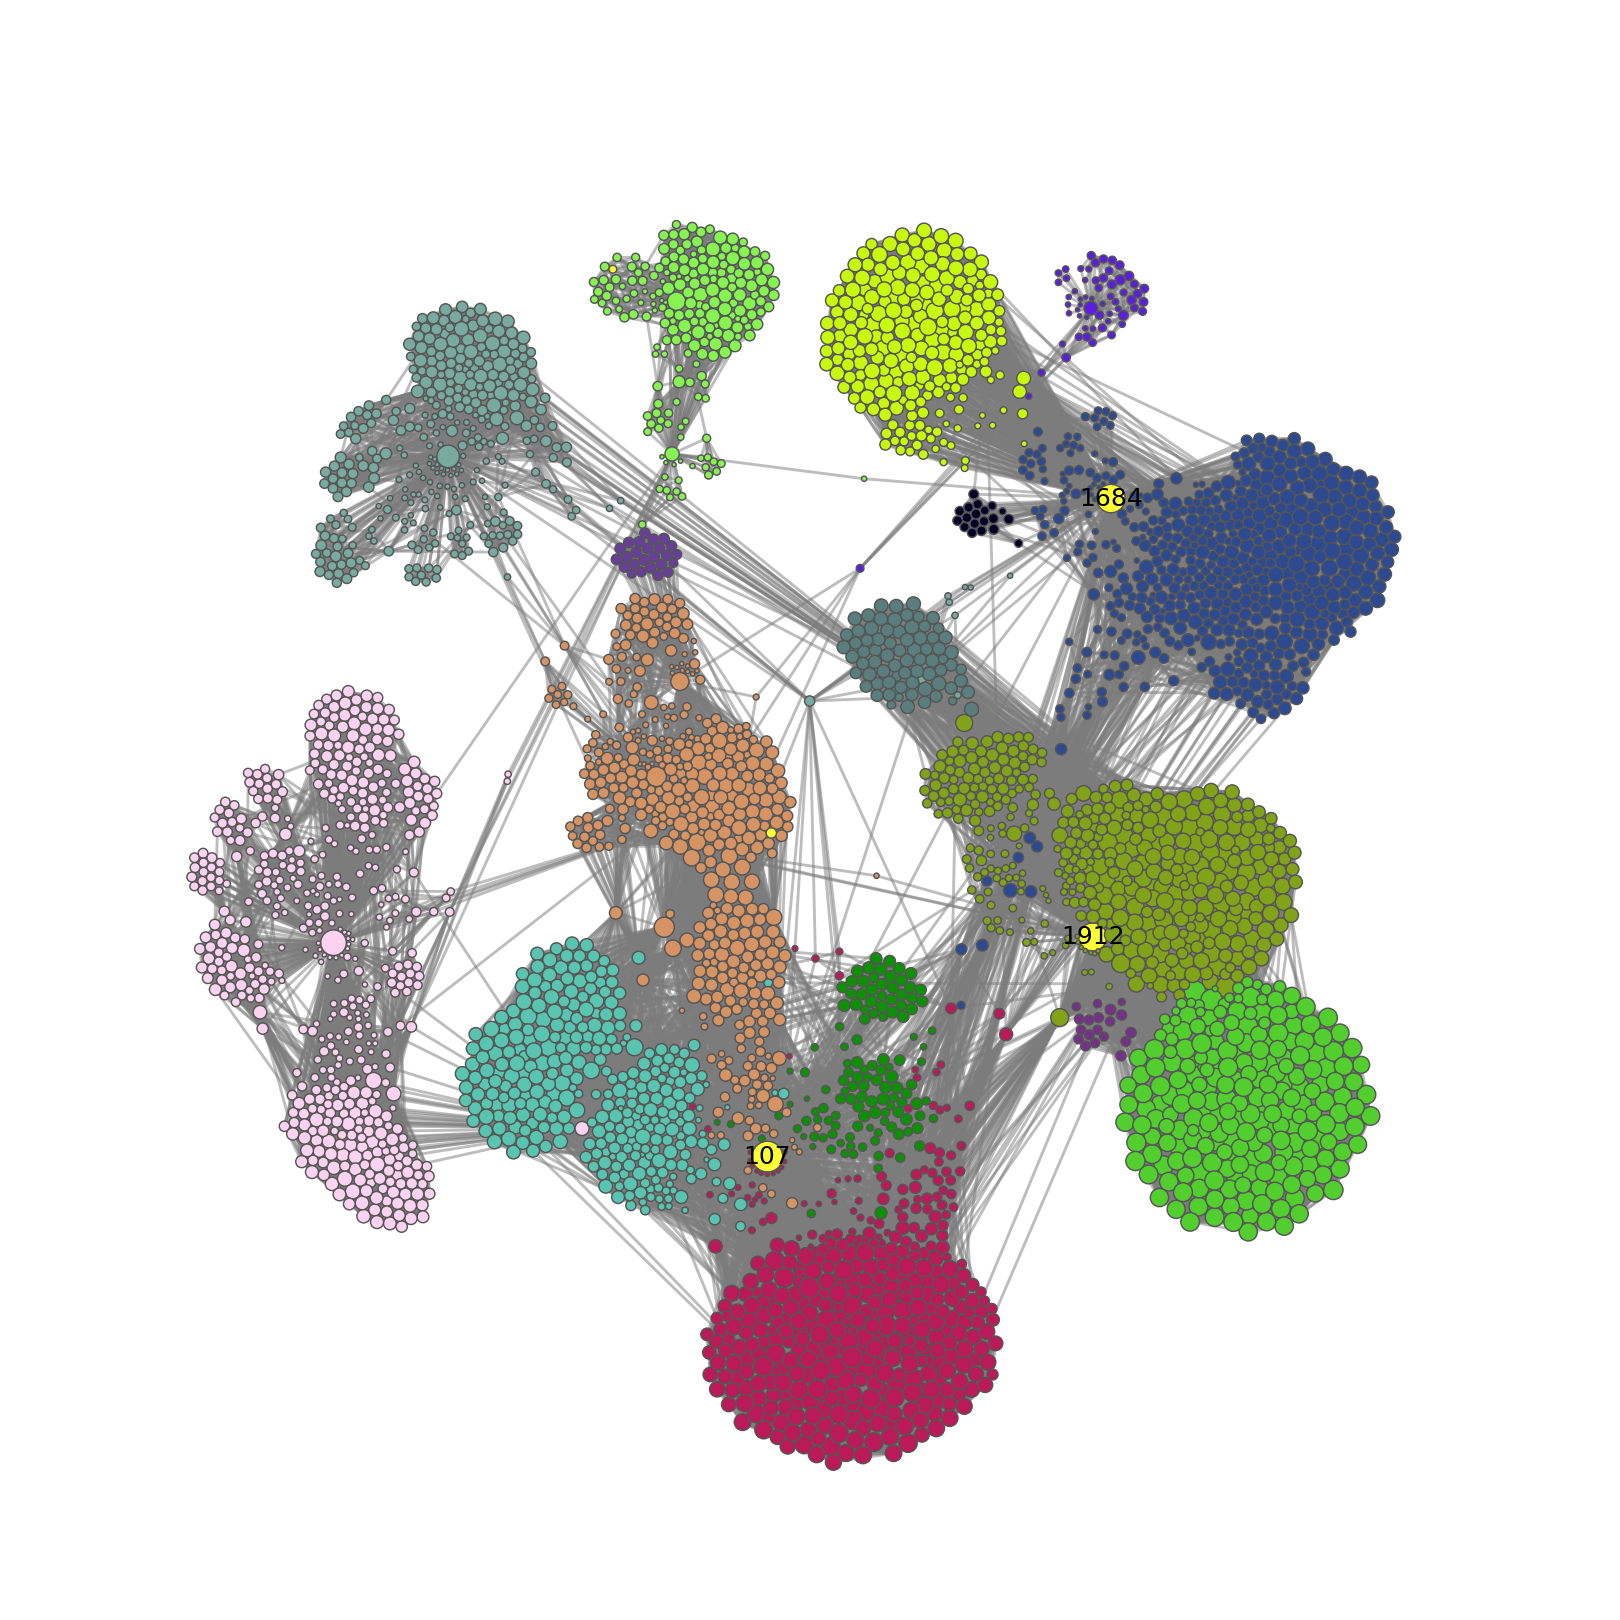

In [186]:
fig, ax = nf.draw_netwulf(stylized_network, figsize=16,)
nf.add_node_label(ax, stylized_network, 107)
nf.add_node_label(ax, stylized_network, 1684)
nf.add_node_label(ax, stylized_network, 1912)

plt.show()

# snapshots

![](../docs/img/netwulf/01_fb.png)

![](../docs/img/netwulf/02_fb.png)

![](../docs/img/netwulf/03_fb.png)

# Trabajo futuro
- 01 - Sistema de recomendación con graph machine learning
- 02 - GNNs
- 03 - Dynamic GNNs

# References



https://towardsdatascience.com/graph-machine-learning-with-python-pt-1-basics-metrics-and-algorithms-cc40972de113

https://towardsdatascience.com/graph-machine-learning-with-python-pt-2-random-graphs-and-diffusion-models-of-cryptopunks-trading-99cd5170b5ea

https://towardsdatascience.com/graph-machine-learning-with-python-part-3-unsupervised-learning-aa2854fe0ff2

https://ericmjl.github.io/Network-Analysis-Made-Simple/01-introduction/03-viz/